In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import os
from scipy.spatial.transform import Rotation as R
import traceback
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

SimFilePath = ['../PickleFiles/SimulationInfo.BWMDC.pickle','../PickleFiles/SimulationInfo.MerianCDM.pickle']
#SimFilePath = ['../PickleFiles/SimulationInfo.MerianSIDM.pickle','../PickleFiles/SimulationInfo.MerianCDM.pickle']
#MassPath = ['../../Data/BasicData/Marvel_DCJL.Masses.pickle','../../Data/BasicData/RDZ.Masses.pickle']
#HaloTypePath = ['../../Data/BasicData/HaloTypes.txt','../../Data/BasicData/HaloTypes.RDZ.txt']
feedback = ['BWMDC','MerianCDM']
reff_multi = 2  # Define this appropriately based on your needs


In [21]:
import numpy as np
from scipy.spatial.transform import Rotation
import pickle
import traceback
import pandas as pd

import numpy as np

def find_valid_rotation_matrices(rbins_s, rbins_d, rotations_s, rotations_d, Reff, sim, hid, threshold=0.1, max_attempts=10):
    """
    Find the closest valid (non-NaN) rotation matrices to Reff for both stellar and dark matter components.
    
    Parameters:
    -----------
    rbins_s, rbins_d : array-like
        Radius bins for stellar and dark matter components
    rotations_s, rotations_d : array-like
        Rotation matrices for stellar and dark matter components
    Reff : float
        Effective radius to find closest bin to
    sim : str
        Simulation identifier (for warning messages)
    hid : int
        Halo ID (for warning messages)
    threshold : float, optional
        Maximum allowed deviation from Reff (default: 0.1)
    max_attempts : int, optional
        Maximum number of attempts to find valid rotation matrices (default: 10)
        
    Returns:
    --------
    rot_stars, rot_dm : array-like
        Valid rotation matrices closest to Reff
    rbins_s_used, rbins_d_used : float
        The actual radius values used for the matrices
    success : bool
        Whether valid rotation matrices were found
    """
    # Make copies to avoid modifying the original arrays
    rbins_s_work = rbins_s.copy()
    rbins_d_work = rbins_d.copy()
    rotations_s_work = rotations_s.copy()
    rotations_d_work = rotations_d.copy()
    
    # Find the closest radius bins to Reff
    idx_s = np.argmin(np.abs(rbins_s_work - Reff))
    idx_d = np.argmin(np.abs(rbins_d_work - Reff))
    
    # Get rotation matrices at closest indices
    rot_stars = rotations_s_work[idx_s]
    rot_dm = rotations_d_work[idx_d]
    
    # Track how far from Reff we are for each component
    rbins_s_used = rbins_s_work[idx_s]
    rbins_d_used = rbins_s_work[idx_d]
    
    # Display warnings for initial radius mismatch
    if np.abs(rbins_s_used - Reff) > threshold:
        print(f'Warning: Stellar Reff mismatch for {sim}, Halo ID: {hid}')
        print(f'Difference: {np.abs(rbins_s_used - Reff):.4f}')
    
    if np.abs(rbins_d_used - Reff) > threshold:
        print(f'Warning: Dark Matter Reff mismatch for {sim}, Halo ID: {hid}')
        print(f'Difference: {np.abs(rbins_d_used - Reff):.4f}')
    
    # Handle NaN values with progressive search
    attempts = 0
    while (np.isnan(rot_stars).any() or np.isnan(rot_dm).any()) and attempts < max_attempts:
        attempts += 1
        
        # Handle NaN in stellar component
        if np.isnan(rot_stars).any():
            # Remove current index with NaN
            mask_s = np.ones(len(rbins_s_work), dtype=bool)
            mask_s[idx_s] = False
            rbins_s_work = rbins_s_work[mask_s]
            rotations_s_work = rotations_s_work[mask_s]
            
            # Find next closest index
            if len(rbins_s_work) > 0:
                idx_s = np.argmin(np.abs(rbins_s_work - Reff))
                rot_stars = rotations_s_work[idx_s]
                rbins_s_used = rbins_s_work[idx_s]
            else:
                print(f'Error: No valid stellar rotation matrices for {sim}, Halo ID: {hid}')
                return None, None, None, None, False
        
        # Handle NaN in dark matter component
        if np.isnan(rot_dm).any():
            # Remove current index with NaN
            mask_d = np.ones(len(rbins_d_work), dtype=bool)
            mask_d[idx_d] = False
            rbins_d_work = rbins_d_work[mask_d]
            rotations_d_work = rotations_d_work[mask_d]
            
            # Find next closest index
            if len(rbins_d_work) > 0:
                idx_d = np.argmin(np.abs(rbins_d_work - Reff))
                rot_dm = rotations_d_work[idx_d]
                rbins_d_used = rbins_d_work[idx_d]
            else:
                print(f'Error: No valid dark matter rotation matrices for {sim}, Halo ID: {hid}')
                return None, None, None, None, False
    
    # If we still have NaNs after max attempts
    if np.isnan(rot_stars).any() or np.isnan(rot_dm).any():
        print(f'Error: Could not find valid rotation matrices after {max_attempts} attempts for {sim}, Halo ID: {hid}')
        return None, None, None, None, False
    
    # Try to align the two radii if they're too far apart
    if abs(rbins_s_used - rbins_d_used) > threshold:
        # Try to find DM radius closer to stellar radius
        idx_d_alt = np.argmin(np.abs(rbins_d_work - rbins_s_used))
        rot_dm_alt = rotations_d_work[idx_d_alt]
        
        # Use this alternative if it's valid and closer
        if not np.isnan(rot_dm_alt).any() and abs(rbins_d_work[idx_d_alt] - rbins_s_used) < abs(rbins_d_used - rbins_s_used):
            rot_dm = rot_dm_alt
            rbins_d_used = rbins_d_work[idx_d_alt]
            print(f'Info: Aligned DM radius with stellar radius for {sim}, Halo ID: {hid}')
            print(f'New difference: {np.abs(rbins_d_used - rbins_s_used):.4f}')
    
    # Final warning if components are still far apart
    if abs(rbins_s_used - rbins_d_used) > threshold:
        print(f'Warning: Stellar and DM components use different radii for {sim}, Halo ID: {hid}')
        print(f'Stellar r: {rbins_s_used:.4f}, DM r: {rbins_d_used:.4f}, Difference: {abs(rbins_s_used - rbins_d_used):.4f}')
    
    return rot_stars, rot_dm, rbins_s_used, rbins_d_used, True




def calculate_orientation_angles(rotation_matrix1, rotation_matrix2):
    """
    Calculate the angles between two sets of principal axes defined by rotation matrices.
    
    Parameters:
    rotation_matrix1, rotation_matrix2: 3x3 numpy arrays representing rotation matrices
    
    Returns:
    dict: Contains absolute angle between orientations and angles between corresponding axes
    """
    # Extract the principal axes (columns of rotation matrices)
    axes1 = [rotation_matrix1[:, i] for i in range(3)]
    axes2 = [rotation_matrix2[:, i] for i in range(3)]
    
    # Calculate angles between corresponding axes
    # Note: We need to consider both positive and negative directions due to axial symmetry
    axis_angles = []
    for i in range(3):
        angle = np.arccos(np.clip(np.abs(np.dot(axes1[i], axes2[i])), -1.0, 1.0))
        angle_deg = np.degrees(angle)
        axis_angles.append(min(angle_deg, 180 - angle_deg))  # Consider symmetry
    
    # Calculate absolute angle between orientations
    # Using Frobenius norm of the difference between rotation matrices
    R_diff = np.dot(rotation_matrix1, rotation_matrix2.T)
    angle = np.arccos(np.clip((np.trace(R_diff) - 1) / 2, -1.0, 1.0))
    abs_angle_deg = np.degrees(angle)
    #abs_angle_deg should not be more than 90, if it is, then it is 180-abs_angle_deg
    if abs_angle_deg > 90:
        abs_angle_deg = 180 - abs_angle_deg
    
    
    return {
        'absolute_angle': abs_angle_deg,
        'axis_a_angle': axis_angles[0],  # x-axis alignment
        'axis_b_angle': axis_angles[1],  # y-axis alignment
        'axis_c_angle': axis_angles[2]   # z-axis alignment
    }

def get_orientation_angles(SimFilePath, feedback, reff_multi):
    diffs_at_Reff = []
    
    for i in range(len(SimFilePath)):
        SimInfo = pickle.load(open(SimFilePath[i], 'rb'))
        
        for sim in SimInfo:
            try:
                StShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle', 'rb'))
                DMShapes = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle', 'rb'))
                Profiles = pickle.load(open(f'../../Data/{sim}.{feedback[i]}.Profiles.pickle', 'rb'))
            except:
                print(f'Error loading {sim} {feedback[i]}')
                continue
                
            for hid in SimInfo[sim]['goodhalos']:
                try:
                    rbins_s = StShapes[hid]['rbins']
                    rbins_d = DMShapes[hid]['rbins']
                    rotations_s = StShapes[hid]['rotations']
                    rotations_d = DMShapes[hid]['rotations']
                    Reff = Profiles[str(hid)]['x000y000']['Reff'] * reff_multi
                    
                    # Find the closest radius bin to Reff
                    idx_s = np.argmin(np.abs(rbins_s - Reff))
                    idx_d = np.argmin(np.abs(rbins_d - Reff))
                    #display warning if the difference is more than 0.5
                    threshold = 0.1
                    if np.abs(rbins_s[idx_s] - Reff) > threshold:
                        print(f'Warning: Stellar Reff mismatch for {sim}, Halo ID: {hid}')
                        print(np.abs(rbins_s[idx_s] - Reff))
                    if np.abs(rbins_d[idx_d] - Reff) > threshold:
                        print(f'Warning: Dark Matter Reff mismatch for {sim}, Halo ID: {hid}')
                        print(np.abs(rbins_d[idx_d] - Reff))
                    
                    # Get rotation matrices at Reff
                    rot_stars = rotations_s[idx_s]
                    rot_dm = rotations_d[idx_d]
                    
                    #print 3rd column of rot_stars and rot_dm
                    print(rot_stars[:,2])
                    print(rot_dm[:,2])
                    
                    
                    # Calculate orientation differences
                    angles = calculate_orientation_angles(rot_stars, rot_dm)
                    
                    # Store results with metadata
                    result = {
                        'simulation': sim,
                        'halo_id': hid,
                        'radius': rbins_s[idx_s],
                        **angles
                    }
                    diffs_at_Reff.append(result)
                    StShapes[hid]['diffs_at_Reff'] = result
                    # 
                    # # Create masks for non-NaN rotation matrices
                    # valid_s_mask = ~np.isnan(rotations_s).any(axis=(1, 2))
                    # valid_d_mask = ~np.isnan(rotations_d).any(axis=(1, 2))
                    # 
                    # # Apply masks to get only valid data points
                    # valid_rbins_s = rbins_s[valid_s_mask]
                    # valid_rotations_s = rotations_s[valid_s_mask]
                    # valid_rbins_d = rbins_d[valid_d_mask]
                    # valid_rotations_d = rotations_d[valid_d_mask]
                    # 
                    # # Check if we have any valid data points
                    # if len(valid_rbins_s) == 0 or len(valid_rbins_d) == 0:
                    #     print(f"Error: No valid rotation matrices for {sim}, Halo ID: {hid}")
                    #     continue  # Skip to the next halo
                    # 
                    # # Find the closest valid radius bin to Reff
                    # idx_s = np.argmin(np.abs(valid_rbins_s - Reff))
                    # idx_d = np.argmin(np.abs(valid_rbins_d - Reff))
                    # 
                    # # Get the actual radii values
                    # r_stars = valid_rbins_s[idx_s]
                    # r_dm = valid_rbins_d[idx_d]
                    # 
                    # # Define threshold for acceptable difference from Reff
                    # threshold = 0.1
                    # 
                    # # Check if stellar radius is too far from Reff
                    # if np.abs(r_stars - Reff) > threshold:
                    #     print(f'Warning: Stellar radius ({r_stars:.3f}) differs from Reff ({Reff:.3f}) by {np.abs(r_stars - Reff):.3f} for {sim}, Halo ID: {hid}')
                    #     
                    # # Check if DM radius is too far from Reff
                    # if np.abs(r_dm - Reff) > threshold:
                    #     print(f'Warning: DM radius ({r_dm:.3f}) differs from Reff ({Reff:.3f}) by {np.abs(r_dm - Reff):.3f} for {sim}, Halo ID: {hid}')
                    # 
                    # # Check if stellar and DM radii are too far apart
                    # if np.abs(r_stars - r_dm) > threshold:
                    #     print(f'Warning: Stellar radius ({r_stars:.3f}) and DM radius ({r_dm:.3f}) differ by {np.abs(r_stars - r_dm):.3f} for {sim}, Halo ID: {hid}')
                    #     
                    #     # Try to find a better matching pair of radii where both have valid rotations
                    #     # Find the radius that's closest to both Reff and has both valid stellar and DM rotations
                    #     common_indices = []
                    #     
                    #     for s_idx, s_r in enumerate(valid_rbins_s):
                    #         # Find the closest DM radius to this stellar radius
                    #         d_idx = np.argmin(np.abs(valid_rbins_d - s_r))
                    #         d_r = valid_rbins_d[d_idx]
                    #         
                    #         if np.abs(s_r - d_r) <= threshold:
                    #             # Calculate a combined distance metric (distance from Reff + distance between radii)
                    #             dist_metric = np.abs(s_r - Reff) + np.abs(d_r - Reff) + np.abs(s_r - d_r)
                    #             common_indices.append((s_idx, d_idx, dist_metric))
                    #     
                    #     if common_indices:
                    #         # Sort by the distance metric and take the best match
                    #         s_idx, d_idx, _ = sorted(common_indices, key=lambda x: x[2])[0]
                    #         idx_s = s_idx
                    #         idx_d = d_idx
                    #         r_stars = valid_rbins_s[idx_s]
                    #         r_dm = valid_rbins_d[idx_d]
                    #         print(f'Found better radius match: stellar={r_stars:.3f}, DM={r_dm:.3f}, Reff={Reff:.3f}')
                    # 
                    # # Get rotation matrices at the chosen radii
                    # rot_stars = valid_rotations_s[idx_s]
                    # rot_dm = valid_rotations_d[idx_d]
                    # 
                    # # Print the 3rd column of rotation matrices for verification
                    # print(f"Stellar rotation 3rd column: {rot_stars[:,2]}")
                    # print(f"DM rotation 3rd column: {rot_dm[:,2]}")
                    # 
                    # # Calculate orientation differences
                    # angles = calculate_orientation_angles(rot_stars, rot_dm)
                    # 
                    # # Store results with metadata
                    # result = {
                    #     'simulation': sim,
                    #     'halo_id': hid,
                    #     'stellar_radius': r_stars,
                    #     'dm_radius': r_dm,
                    #     'reff': Reff,
                    #     **angles
                    # }
                    # diffs_at_Reff.append(result)
                    # StShapes[hid]['diffs_at_Reff'] = result
                    
                except:
                    print(traceback.format_exc())
                    
            print('saving to pickle')
            
            #DMShapes[hid]['diffs_at_Reff'] = diffs_at_Reff
            pickle.dump(StShapes, open(f'../../Data/{sim}.{feedback[i]}.3DShapes.pickle', 'wb'))
            #pickle.dump(DMShapes, open(f'../../Data/{sim}.{feedback[i]}.DMShapes.pickle', 'wb'))

    return diffs_at_Reff

def plot_angle_distributions(diffs_at_Reff):
    """
    Plot histograms of the orientation angles between dark matter and stellar components
    
    Parameters:
    diffs_at_Reff: List of dictionaries containing angle measurements
    """
    # Convert list of dictionaries to arrays
    abs_angles = np.array([d['absolute_angle'] for d in diffs_at_Reff])
    axis_a_angles = np.array([d['axis_a_angle'] for d in diffs_at_Reff])
    axis_b_angles = np.array([d['axis_b_angle'] for d in diffs_at_Reff])
    axis_c_angles = np.array([d['axis_c_angle'] for d in diffs_at_Reff])
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Distribution of Alignment Angles between Dark Matter and Stellar Components', fontsize=14)
    
    # Common histogram parameters
    bins = np.arange(0, 91, 10)  # 10-degree bins from 0 to 90
    hist_kwargs = dict(
        bins=bins,
        density=True,
        alpha=0.7,
        color='blue',
        edgecolor='black'
    )
    
    # Plot absolute angles
    ax1.hist(abs_angles, **hist_kwargs)
    ax1.set_title('Absolute Orientation Angle')
    ax1.set_xlabel('Angle (degrees)')
    ax1.set_ylabel('Normalized Frequency')
    
    # Plot axis a angles
    ax2.hist(axis_a_angles, **hist_kwargs)
    ax2.set_title('Major Axis (a) Alignment')
    ax2.set_xlabel('Angle (degrees)')
    ax2.set_ylabel('Normalized Frequency')
    
    # Plot axis b angles
    ax3.hist(axis_b_angles, **hist_kwargs)
    ax3.set_title('Intermediate Axis (b) Alignment')
    ax3.set_xlabel('Angle (degrees)')
    ax3.set_ylabel('Normalized Frequency')
    
    # Plot axis c angles
    ax4.hist(axis_c_angles, **hist_kwargs)
    ax4.set_title('Minor Axis (c) Alignment')
    ax4.set_xlabel('Angle (degrees)')
    ax4.set_ylabel('Normalized Frequency')
    
    # Add summary statistics as text
    stats_text = (
        f'Number of halos: {len(diffs_at_Reff)}\n'
        f'Mean absolute angle: {np.nanmean(abs_angles):.1f}°\n'
        f'Mean axis angles:\n'
        f'  a: {np.nanmean(axis_a_angles):.1f}°\n'
        f'  b: {np.nanmean(axis_b_angles):.1f}°\n'
        f'  c: {np.nanmean(axis_c_angles):.1f}°'
    )
    fig.text(0.02, 0.98, stats_text, fontsize=10, va='top', ha='left')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    return fig




[ 0.03101547 -0.03829     0.99878522]
[ 0.08484898 -0.09190712  0.99214602]
[ 0.00616446 -0.00266109  0.99997746]
[0.0025552  0.01739339 0.99984546]
[nan nan nan]
[0.02651398 0.00602979 0.99963026]
[0.03066636 0.26622081 0.96342413]
[0.04846728 0.33896346 0.93955026]
[ 0.40054812  0.871479   -0.28299391]
[ 0.24830128  0.83078497 -0.49813935]
[0.04875481 0.15528507 0.98666586]
[0.05815329 0.13791979 0.98873471]
[ 0.88094282  0.33278187 -0.33644611]
[-0.77704354  0.15867292  0.60911924]
saving to pickle
[-0.01978651  0.04335665  0.9988637 ]
[-0.01195235 -0.02517993  0.99961148]
[-0.58976412  0.60559789 -0.53425601]
[-0.52013877  0.11075229 -0.84687047]
[-0.06422409  0.02111371 -0.99771212]
[0.02865293 0.02050646 0.99937905]
[-0.09545024 -0.00840146  0.99539875]
[ 0.08551549  0.02403289 -0.99604695]
[0.08764746 0.40885115 0.90838244]
[0.08821419 0.49073157 0.86683377]
[-0.61979844  0.6556501   0.43124569]
[-0.6807639   0.65172692  0.3343838 ]
[0.56249804 0.34595833 0.75093861]
[0.42434083

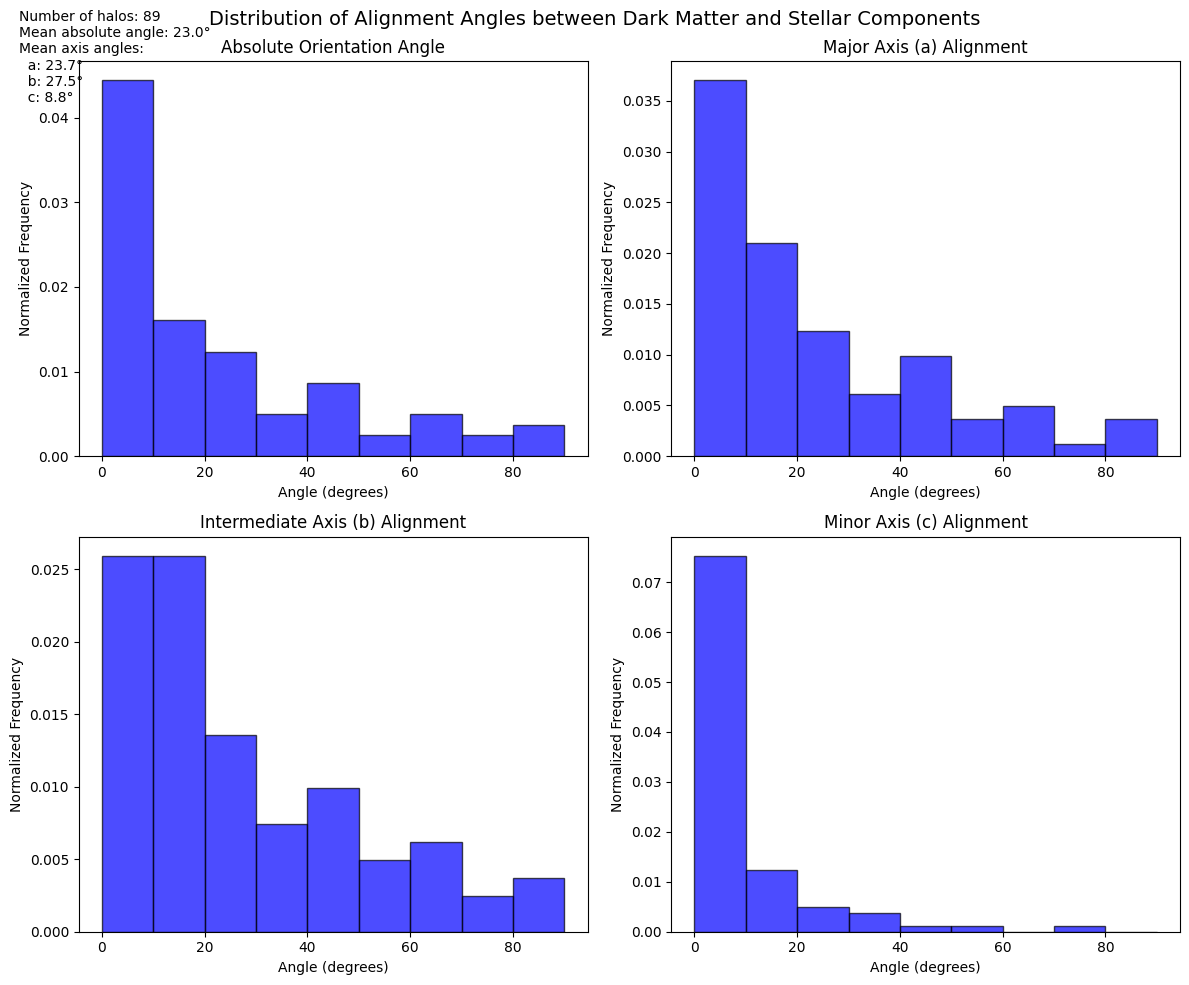

In [22]:


diffs_at_Reff = get_orientation_angles(SimFilePath, feedback, reff_multi)

fig = plot_angle_distributions(diffs_at_Reff)

In [29]:
print(diffs_at_Reff)

[{'simulation': 'cptmarvel', 'halo_id': 1, 'radius': 1.1921934264183585, 'absolute_angle': 13.605881303595092, 'axis_a_angle': 13.507361725405874, 'axis_b_angle': 13.544100226778202, 'axis_c_angle': 2.075694625617635}, {'simulation': 'cptmarvel', 'halo_id': 2, 'radius': 1.7999902263277663, 'absolute_angle': 11.691996405825474, 'axis_a_angle': 11.289312114733551, 'axis_b_angle': 11.690627875236157, 'axis_c_angle': 3.037469692005635}, {'simulation': 'cptmarvel', 'halo_id': 3, 'radius': 0.7981366009237243, 'absolute_angle': 149.63295015131493, 'axis_a_angle': 30.640041592293578, 'axis_b_angle': 30.573758360316504, 'axis_c_angle': 5.282996470617029}, {'simulation': 'cptmarvel', 'halo_id': 5, 'radius': 0.7291244278752737, 'absolute_angle': 27.69298117842176, 'axis_a_angle': 22.462529202241928, 'axis_b_angle': 23.035022514747673, 'axis_c_angle': 22.10349549954775}, {'simulation': 'cptmarvel', 'halo_id': 6, 'radius': 0.5468342222497418, 'absolute_angle': 14.935342423395026, 'axis_a_angle': 7.


Test: No rotation
Expected absolute angle: 0.0°
Calculated absolute angle: 0.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 180° rotation around x-axis
Expected absolute angle: 180.0°
Calculated absolute angle: 180.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 180° rotation around y-axis
Expected absolute angle: 180.0°
Calculated absolute angle: 180.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 180° rotation around z-axis
Expected absolute angle: 180.0°
Calculated absolute angle: 180.0°
Axis angles: a=0.0°, b=0.0°, c=0.0°

Test: 90° rotation around x-axis
Expected absolute angle: 90.0°
Calculated absolute angle: 90.0°
Axis angles: a=0.0°, b=90.0°, c=90.0°

Test: 90° rotation around y-axis
Expected absolute angle: 90.0°
Calculated absolute angle: 90.0°
Axis angles: a=90.0°, b=0.0°, c=90.0°

Test: 90° rotation around z-axis
Expected absolute angle: 90.0°
Calculated absolute angle: 90.0°
Axis angles: a=90.0°, b=90.0°, c=0.0°


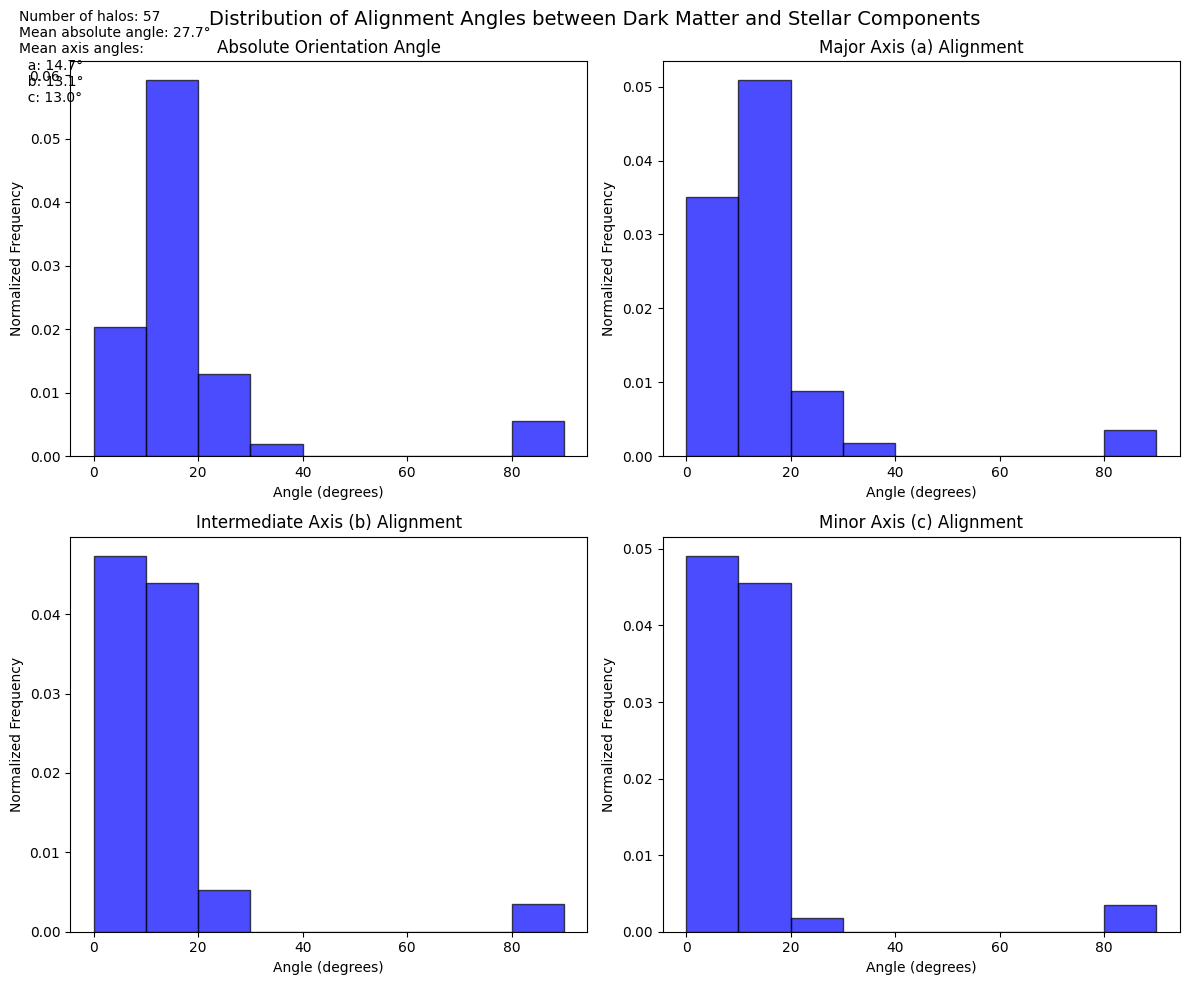


Summary of random rotation results:
Mean absolute angle: 15.3°
Std absolute angle: 5.7°


In [23]:
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

def create_test_rotations(n_random=50, seed=42):
    """
    Create test cases for rotation comparisons including:
    - Identity (no rotation)
    - 180° rotations around each axis
    - 90° rotations around each axis
    - Random rotations with controlled perturbations
    
    Returns:
    list of dictionaries containing test cases and expected results
    """
    np.random.seed(seed)
    test_cases = []
    
    # Identity matrix as reference
    base_matrix = np.eye(3)
    
    # Helper function to create rotation matrix
    def create_rotation_matrix(axis, angle_deg):
        angle_rad = np.radians(angle_deg)
        c, s = np.cos(angle_rad), np.sin(angle_rad)
        if axis == 'x':
            return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
        elif axis == 'y':
            return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
        else:  # z
            return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    
    # Test Case 1: Identity (no rotation)
    test_cases.append({
        'name': 'No rotation',
        'matrix1': base_matrix,
        'matrix2': base_matrix,
        'expected_absolute': 0
    })
    
    # Test Case 2-4: 180° rotations around each axis
    for axis, axis_vector in zip(['x', 'y', 'z'], [[1,0,0], [0,1,0], [0,0,1]]):
        rot_matrix = create_rotation_matrix(axis, 180)
        test_cases.append({
            'name': f'180° rotation around {axis}-axis',
            'matrix1': base_matrix,
            'matrix2': rot_matrix,
            'expected_absolute': 180
        })
    
    # Test Case 5-7: 90° rotations around each axis
    for axis in ['x', 'y', 'z']:
        rot_matrix = create_rotation_matrix(axis, 90)
        test_cases.append({
            'name': f'90° rotation around {axis}-axis',
            'matrix1': base_matrix,
            'matrix2': rot_matrix,
            'expected_absolute': 90
        })
    
    # Random rotations with controlled perturbations
    for i in range(n_random):
        # Create random rotation angles with some noise
        angles = np.random.normal(0, 10, 3)  # mean=0, std=10 degrees
        rot = Rotation.from_euler('xyz', angles, degrees=True)
        rot_matrix = rot.as_matrix()
        
        test_cases.append({
            'name': f'Random rotation {i}',
            'matrix1': base_matrix,
            'matrix2': rot_matrix,
            'expected_absolute': np.linalg.norm(angles)  # approximate
        })
    
    return test_cases

def test_orientation_calculations():
    """
    Test the calculate_orientation_angles function with various rotation scenarios
    """
    test_cases = create_test_rotations()
    results = []
    
    for case in test_cases:
        angles = calculate_orientation_angles(case['matrix1'], case['matrix2'])
        results.append({
            'name': case['name'],
            'expected_absolute': case['expected_absolute'],
            **angles
        })
        
        # Print detailed results for specific test cases
        if 'Random' not in case['name']:
            print(f"\nTest: {case['name']}")
            print(f"Expected absolute angle: {case['expected_absolute']:.1f}°")
            print(f"Calculated absolute angle: {angles['absolute_angle']:.1f}°")
            print(f"Axis angles: a={angles['axis_a_angle']:.1f}°, "
                  f"b={angles['axis_b_angle']:.1f}°, "
                  f"c={angles['axis_c_angle']:.1f}°")
    
    return results

# Run tests and create visualization
test_results = test_orientation_calculations()

# Create histograms
fig = plot_angle_distributions(test_results)

# Add special markers for the specific test cases
def add_markers_to_histogram(ax, values, label):
    """Add vertical lines for specific test cases"""
    for val in values:
        if val > 0:  # Only mark non-zero values
            ax.axvline(x=val, color='red', linestyle='--', alpha=0.5)

# Get values for specific test cases
specific_cases = [case for case in test_results if 'Random' not in case['name']]
absolute_angles = [case['absolute_angle'] for case in specific_cases]

# Add markers to the absolute angle histogram (assumed to be the first subplot)
#add_markers_to_histogram(plt.gcf().axes[0], absolute_angles, 'Specific test cases')

plt.show()

# Print summary statistics
print("\nSummary of random rotation results:")
random_results = [case for case in test_results if 'Random' in case['name']]
abs_angles = [case['absolute_angle'] for case in random_results]
print(f"Mean absolute angle: {np.mean(abs_angles):.1f}°")
print(f"Std absolute angle: {np.std(abs_angles):.1f}°")

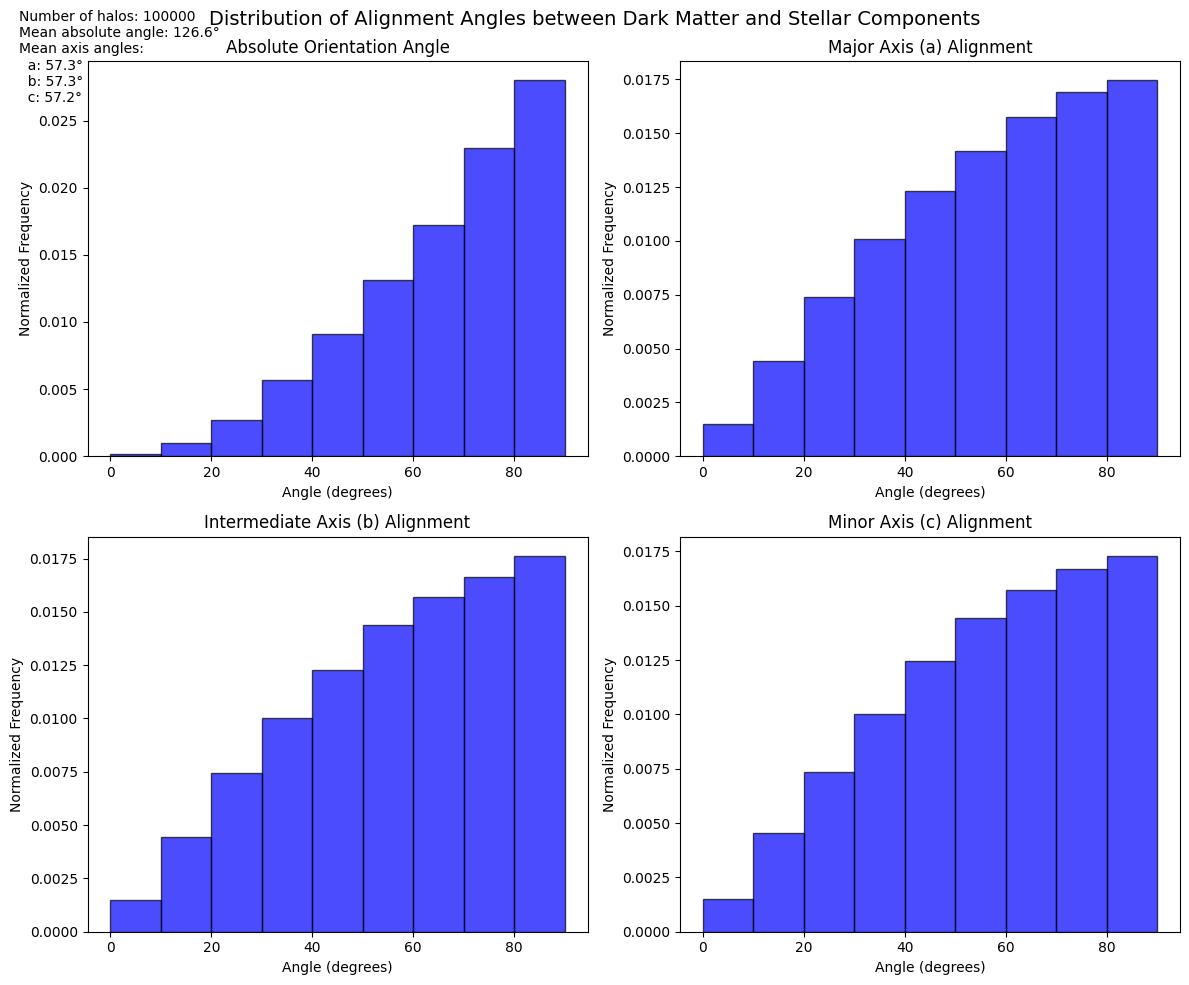


Summary Statistics:
Number of samples: 100000

Absolute angles:
Mean: 126.6°
Median: 132.5°
Std: 37.0°

Axis angles:
A - Mean: 57.3°, Median: 60.1°, Std: 21.5°
B - Mean: 57.3°, Median: 60.0°, Std: 21.6°
C - Mean: 57.2°, Median: 59.8°, Std: 21.5°

Correlations between axes:
    A     B     C
A: 1.000 0.246 0.239
B: 0.246 1.000 0.244
C: 0.239 0.244 1.000


In [26]:
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

def generate_uniform_rotations(n_samples=1000, seed=42):
    """
    Generate uniformly distributed random rotations in SO(3) space using quaternions.
    This method ensures proper uniform sampling in 3D rotation space.
    
    Parameters:
    n_samples: number of random rotations to generate
    seed: random seed for reproducibility
    
    Returns:
    list of dictionaries containing rotation matrices and their comparisons
    """
    np.random.seed(seed)
    
    def random_rotation_matrix():
        """Generate a random rotation matrix using quaternions"""
        # Generate random quaternion components
        x, y, z, w = np.random.normal(0, 1, 4)
        # Normalize to ensure it's a valid rotation
        norm = np.sqrt(x*x + y*y + z*z + w*w)
        q = np.array([x/norm, y/norm, z/norm, w/norm])
        return Rotation.from_quat(q).as_matrix()
    
    results = []
    base_matrix = np.eye(3)  # Reference orientation
    
    # Generate pairs of random rotations and calculate their relative orientations
    for i in range(n_samples):
        rot_matrix = random_rotation_matrix()
        angles = calculate_orientation_angles(base_matrix, rot_matrix)
        
        results.append({
            'name': f'Random rotation {i}',
            **angles
        })
    
    return results

# Generate random rotations and analyze them
n_samples = 10000
random_results = generate_uniform_rotations(n_samples)

# Create histograms
fig = plot_angle_distributions(random_results)

# Print summary statistics
abs_angles = [case['absolute_angle'] for case in random_results]
axis_a_angles = [case['axis_a_angle'] for case in random_results]
axis_b_angles = [case['axis_b_angle'] for case in random_results]
axis_c_angles = [case['axis_c_angle'] for case in random_results]

print("\nSummary Statistics:")
print(f"Number of samples: {n_samples}")
print("\nAbsolute angles:")
print(f"Mean: {np.mean(abs_angles):.1f}°")
print(f"Median: {np.median(abs_angles):.1f}°")
print(f"Std: {np.std(abs_angles):.1f}°")

print("\nAxis angles:")
print(f"A - Mean: {np.mean(axis_a_angles):.1f}°, Median: {np.median(axis_a_angles):.1f}°, Std: {np.std(axis_a_angles):.1f}°")
print(f"B - Mean: {np.mean(axis_b_angles):.1f}°, Median: {np.median(axis_b_angles):.1f}°, Std: {np.std(axis_b_angles):.1f}°")
print(f"C - Mean: {np.mean(axis_c_angles):.1f}°, Median: {np.median(axis_c_angles):.1f}°, Std: {np.std(axis_c_angles):.1f}°")

# Additional check: Calculate correlations between axes
correlations = np.corrcoef([axis_a_angles, axis_b_angles, axis_c_angles])
print("\nCorrelations between axes:")
print("    A     B     C")
print(f"A: {correlations[0,0]:.3f} {correlations[0,1]:.3f} {correlations[0,2]:.3f}")
print(f"B: {correlations[1,0]:.3f} {correlations[1,1]:.3f} {correlations[1,2]:.3f}")
print(f"C: {correlations[2,0]:.3f} {correlations[2,1]:.3f} {correlations[2,2]:.3f}")

# Optional: Add theoretical expectations for uniform distribution
def add_theoretical_distribution(ax):
    """Add theoretical distribution curve for uniform random rotations"""
    x = np.linspace(0, 90, 100)
    # Theoretical distribution for random 3D rotations (simplified)
    y = np.sin(np.radians(x)) / 90
    ax.plot(x, y, 'r--', label='Theoretical', alpha=0.7)
    ax.legend()

# Add theoretical curves to each subplot
for ax in fig.axes:
    add_theoretical_distribution(ax)

plt.show()